In [1]:
from enum import Enum

class Color(Enum):
    White = 0
    Grey  = 1
    Black = 2

In [2]:
def find_leafs(graph):
    leafs = set()
    colors = dict()
    for node in graph.keys():
        colors[node] = Color.White
        
    def dfs_find_leafs(node):
        colors[node] = Color.Grey

        successors = graph[node]
        for s in successors:
            if colors[s] == Color.White:
                dfs_find_leafs(s)

        if successors == set():
            leafs.add(node)

        colors[node] = Color.Black
        
    for node in graph.keys():
        if colors[node] == Color.White:
            dfs_find_leafs(node)
            
    return leafs

def has_cycles(graph):
    
    colors = dict()
    for node in graph.keys():
        colors[node] = Color.White
        
    def dfs_has_cycles(node):
        if colors[node] == Color.Grey:
            return True
        
        colors[node] = Color.Grey

        successors = graph[node]
        for s in successors:
            if colors[s] != Color.Black:
                if dfs_has_cycles(s):
                    return True

        colors[node] = Color.Black
        return False
        
    for node in graph.keys():
        if colors[node] == Color.White:
            if dfs_has_cycles(node):
                return True
            
    return False

def inverse_graph(graph):
    inversed_graph = {node : set() for node in graph}
    for node, successors in graph.items():
        for s in successors:
            inversed_graph[s].add(node)
            
    return inversed_graph

def topological_sort(graph, entry_node = 'Start'):
    topological = list()
    
    colors = dict()
    for node in graph.keys():
        colors[node] = Color.White
        
    def dfs(node):
        assert colors[node] != Color.Grey, 'Graph is not DAG'
        
        colors[node] = Color.Grey

        successors = graph[node]
        for s in successors:
            if colors[s] != Color.Black:
                dfs(s)
        
        topological.append(node)

        colors[node] = Color.Black
                
    dfs(entry_node) 
    
    topological.reverse()
    return topological

def find_dominators(graph, entry_node = 'Start'):
    predecessors = inverse_graph(graph)
    successors = graph

    # Каждый узел -- сам себе доминатор
    doms = {node : set([node]) for node in graph}

    # Т.к. граф отсортирован топологически, находим доминаторов за линию
    for node in topological_sort(graph, entry_node = entry_node):
        preds_doms = set()
        for p in predecessors[node]:
            preds_doms = preds_doms.intersection(doms[p]) if preds_doms else doms[p]
            
        doms[node] = set.union(set([node]), preds_doms)

    return doms

def dominator_tree(graph, entry_node = 'Start'):
    dominators = find_dominators(graph, entry_node = entry_node)
    
    topological = dict()
    for i, node in enumerate(topological_sort(graph, entry_node = entry_node)):
        topological[node] = i
        
    tree = {node : set() for node in graph}
    for node, doms in dominators.items():
        selfdom, idom, *_ = sorted(doms, key = lambda node: topological[node], reverse = True) + [None]
        if idom:
            tree[idom].add(node)
            
    return tree

In [31]:
from graphviz import Digraph

def dump_graphviz(graph, label = lambda node: node):
    dot = Digraph()
    for node, successors in graph.items():
        dot.node(node, label = label(node), shape = 'rectangle', fontname = 'Consolas', style = 'rounded')
        for s in successors:
            dot.edge(node, s)
            
    return dot

def parse_graph(entries):
    graph = dict()
    for entry in entries:
        node, *successors = entry.split()
        graph[node] = set(successors)

    for node, successsors in graph.copy().items():
        for s in successsors:
            if s not in graph:
                # Add nodes with empty adjacency list
                graph[s] = set()

    return graph

## 1. Построить граф на основе списков смежности

In [57]:
in_graph = []
with open('test-multi.txt') as f:
    in_graph = f.readlines()

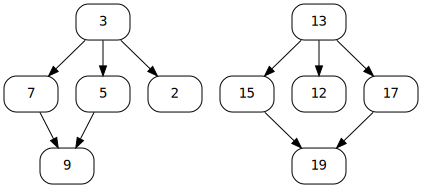

In [58]:
graph = parse_graph(in_graph)
dump_graphviz(graph)

## 2. Достроить узлы Start и End (связать все подграфы в единый граф)

In [59]:
to_end = find_leafs(graph)
to_end

{'12', '19', '2', '9'}

In [60]:
to_start = find_leafs(inverse_graph(graph))
to_start

{'13', '3'}

Вставляем Start и End:

In [71]:

graph['Start'] = set()
graph['End'] = set()

for node in to_end:
    graph[node].add('End')
    
for node in to_start:
    graph['Start'].add(node)

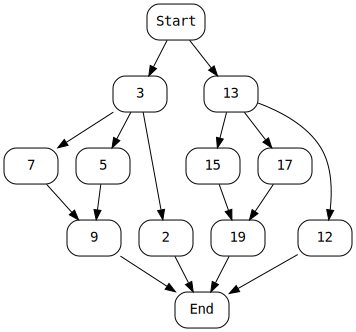

In [72]:
dump_graphviz(graph)

## 3. Убедиться, что данный граф ациклический

In [73]:
assert has_cycles(graph) == False

## 4. Провести топологическую сортировку данного графа.

In [64]:
topological_order = topological_sort(graph)
topological_order

['Start', '3', '2', '5', '7', '9', '13', '17', '12', '15', '19', 'End']

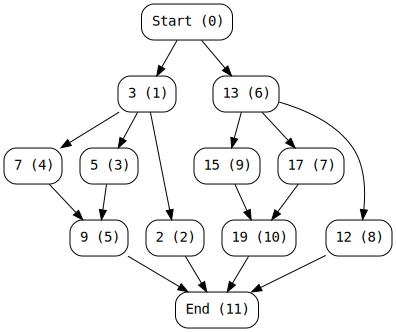

In [65]:
topological = dict()
for i, node in enumerate(topological_sort(graph)):
    topological[node] = i
    
dump_graphviz(graph, label = lambda node: f'{node} ({topological[node]})')

## 5. Построить дерево доминаторов данного графа

In [66]:
doms = find_dominators(graph, entry_node = 'Start')
doms

{'3': {'3', 'Start'},
 '5': {'3', '5', 'Start'},
 '7': {'3', '7', 'Start'},
 '13': {'13', 'Start'},
 '15': {'13', '15', 'Start'},
 '17': {'13', '17', 'Start'},
 '2': {'2', '3', 'Start'},
 '9': {'3', '9', 'Start'},
 '12': {'12', '13', 'Start'},
 '19': {'13', '19', 'Start'},
 'Start': {'Start'},
 'End': {'End', 'Start'}}

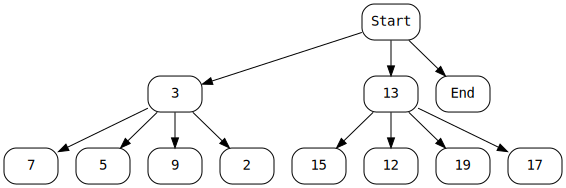

In [67]:
dom_tree = dominator_tree(graph, entry_node = 'Start')
dump_graphviz(dom_tree)

## 6. Построить дерево постдоминаторов данного графа

Постдоминатор - это доминатор обратного графа

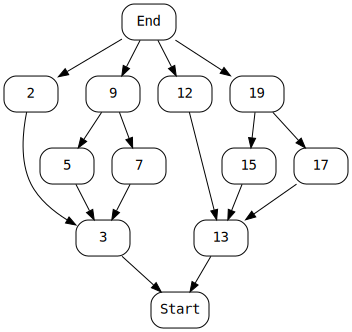

In [68]:
inversed_graph = inverse_graph(graph)
dump_graphviz(inversed_graph)

In [69]:
postdoms = find_dominators(inversed_graph, entry_node = 'End')
postdoms

{'3': {'3', 'End'},
 '5': {'5', '9', 'End'},
 '7': {'7', '9', 'End'},
 '13': {'13', 'End'},
 '15': {'15', '19', 'End'},
 '17': {'17', '19', 'End'},
 '2': {'2', 'End'},
 '9': {'9', 'End'},
 '12': {'12', 'End'},
 '19': {'19', 'End'},
 'Start': {'End', 'Start'},
 'End': {'End'}}

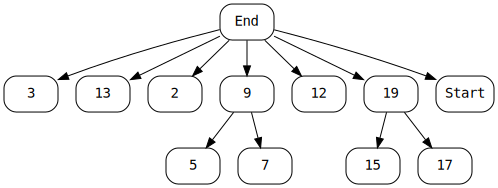

In [70]:
postdom_tree = dominator_tree(inversed_graph, entry_node = 'End')
dump_graphviz(postdom_tree)